In [1]:
import torch
import torch.optim as optim
from avalanche.benchmarks import PermutedMNIST
from avalanche.models import SimpleMLP
from avalanche.training.supervised import EWC
from avalanche.evaluation.metrics import accuracy_metrics, loss_metrics, forgetting_metrics
from avalanche.logging import InteractiveLogger
from avalanche.training.plugins import EvaluationPlugin
import matplotlib.pyplot as plt


/home/mathis/miniconda3/envs/.jax_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 0. Check if GPU is available
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda:2


In [3]:
# 1. Create the benchmark
benchmark = PermutedMNIST(n_experiences=3, seed=1)

In [4]:
# 2. Create the model
model = SimpleMLP(num_classes=benchmark.n_classes).to(device)

In [5]:
# 3. Create the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [6]:
# 4. Create the EWC strategy
interactive_logger = InteractiveLogger()
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    loss_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    forgetting_metrics(experience=True, stream=True),
    loggers=[interactive_logger]
)

ewc = EWC(
    model, optimizer, criterion=torch.nn.CrossEntropyLoss(), ewc_lambda=0.4,
    train_mb_size=32, train_epochs=2, eval_mb_size=100, evaluator=eval_plugin,
    device=device
)

/home/mathis/miniconda3/envs/.jax_env/lib/python3.12/site-packages/avalanche/training/templates/base.py:468: PositionalArgumentsDeprecatedWarning: Avalanche is transitioning to strategy constructors that accept named (keyword) arguments only. This is done to ensure that there is no confusion regarding the meaning of each argument (strategies can have many arguments). Your are passing 2 positional arguments to the EWC.__init__ method. Consider passing them as names arguments. The ability to pass positional arguments will be removed in the future.
  warnings.warn(error_str, category=PositionalArgumentsDeprecatedWarning)


In [7]:
# 5. Training loop with evaluation
results = []

for experience in benchmark.train_stream:
    ewc.train(experience)
    results.append(ewc.eval(benchmark.test_stream))

-- >> Start of training phase << --
100%|██████████| 1875/1875 [00:12<00:00, 150.49it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2841
	Loss_MB/train_phase/train_stream/Task000 = 0.1327
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9140
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.9375
100%|██████████| 1875/1875 [00:12<00:00, 151.49it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.1511
	Loss_MB/train_phase/train_stream/Task000 = 0.0497
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9537
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.9688
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 100/100 [00:01<00:00, 75.94it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = 0.0986
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.9687
-- Starting eval on experience 1 (Task 0

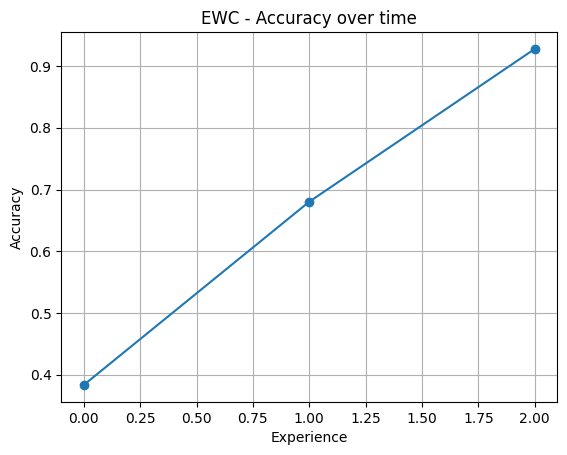

In [8]:
# 6. Plot the results
accuracies = [r['Top1_Acc_Stream/eval_phase/test_stream/Task000'] for r in results]

plt.figure()
plt.plot(accuracies, marker='o')
plt.title('EWC - Accuracy over time')
plt.xlabel('Experience')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()
